In [234]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import sklearn.metrics as skm
import statsmodels.api as sm
import math
from scipy.stats import norm

#df = pd.DataFrame(pd.read_pickle("../data/pricespaths.pickle")).T
df = pd.DataFrame(pd.read_csv("../data/training_pricepaths.csv"))

In [3]:
df.head()


,Unnamed: 0,underlying,call65,call70,call75,call80,call85,call90,call95,call100,...,put90,put95,put100,put105,put110,put115,put120,put125,put130,put135
0,0,100.000000,35.436537,30.436449,25.465460,20.544501,15.718957,11.091298,6.883928,3.493461,...,1.091298,1.883928,3.493461,6.333979,10.375479,15.090290,20.025352,25.011182,30.008593,35.010526
1,1,99.703351,35.117638,30.116325,25.143759,20.221087,15.395046,10.773197,6.591873,3.268877,...,1.069846,1.888522,3.565526,6.509131,10.632709,15.380026,20.322307,25.309459,30.307651,35.311125
2,2,99.781739,35.246585,30.252950,25.291467,20.385660,15.585513,11.000335,6.856841,3.536347,...,1.218595,2.075101,3.754608,6.627924,10.649909,15.334966,20.254847,25.235405,30.231430,35.233703
3,3,99.989922,35.412877,30.423416,25.464844,20.560375,15.759372,11.169538,7.013417,3.664809,...,1.179616,2.023495,3.674888,6.502648,10.479730,15.139596,20.050467,25.028339,30.023364,35.024824
4,4,99.348765,34.765348,29.783212,24.834189,19.944124,15.167839,10.623611,6.550014,3.329964,...,1.274847,2.201250,3.981199,6.956351,11.042635,15.753561,20.681516,25.664342,30.660513,35.661443


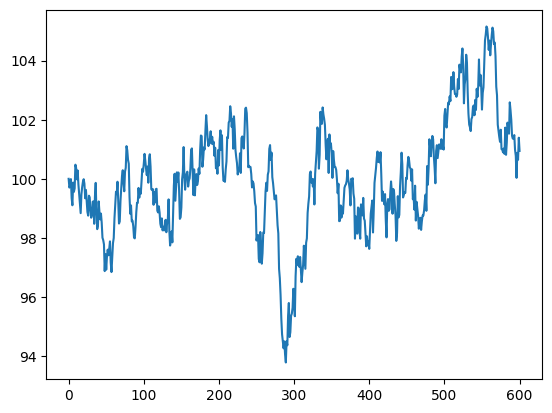

In [14]:
asset_price = df['underlying'].to_numpy()
plt.plot(asset_price)
plt.show()

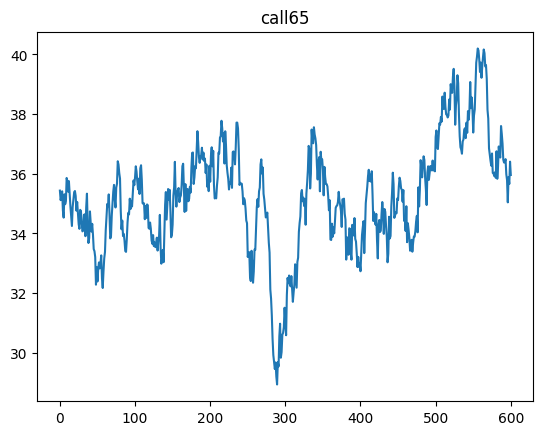

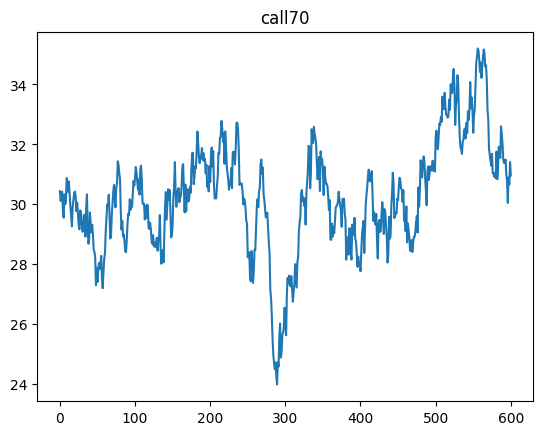

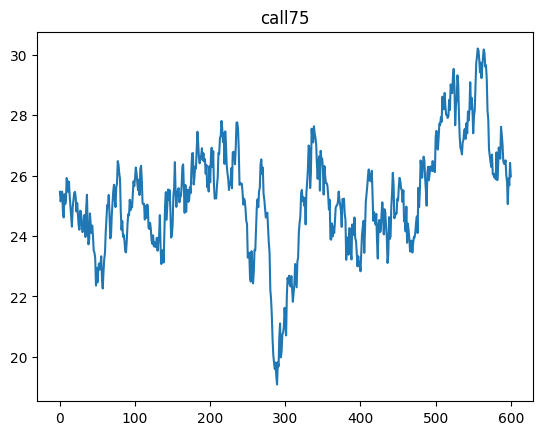

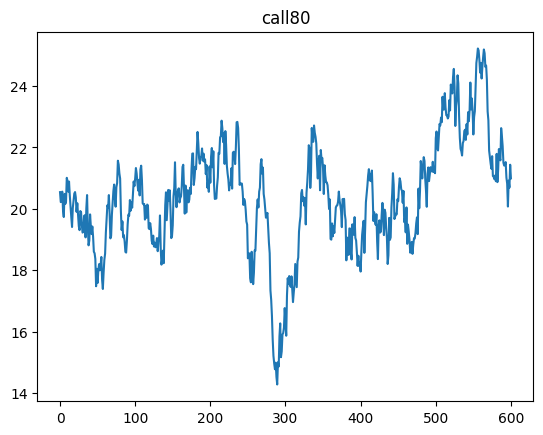

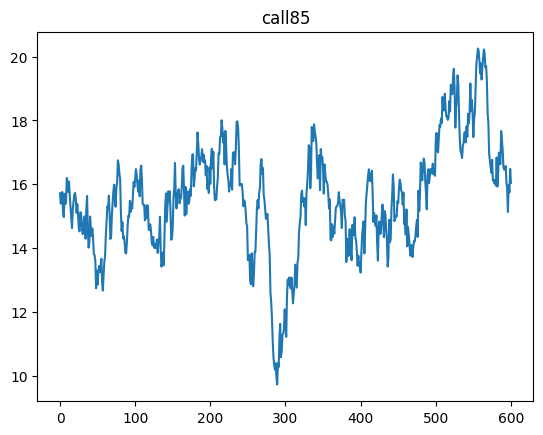

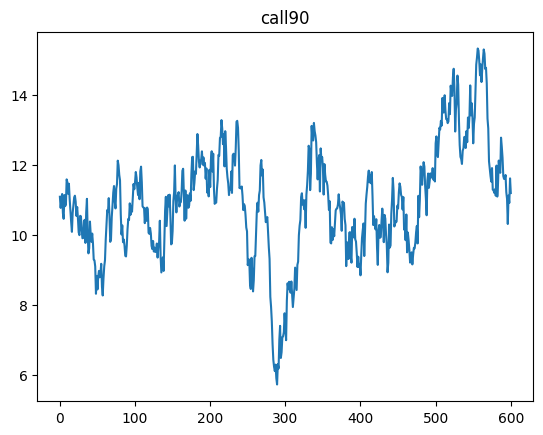

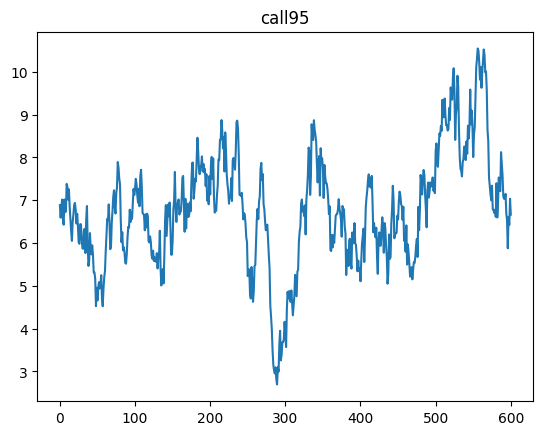

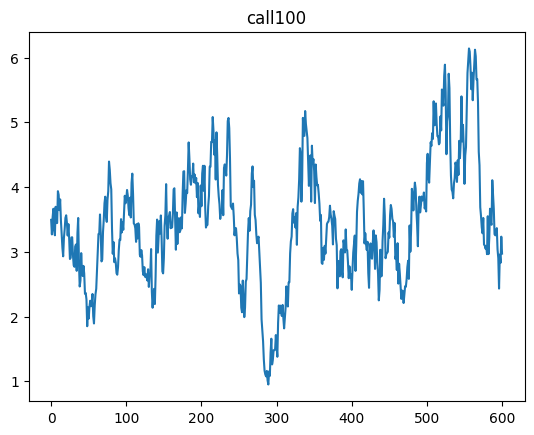

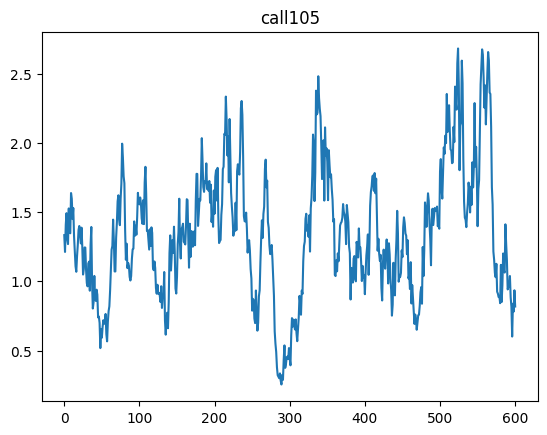

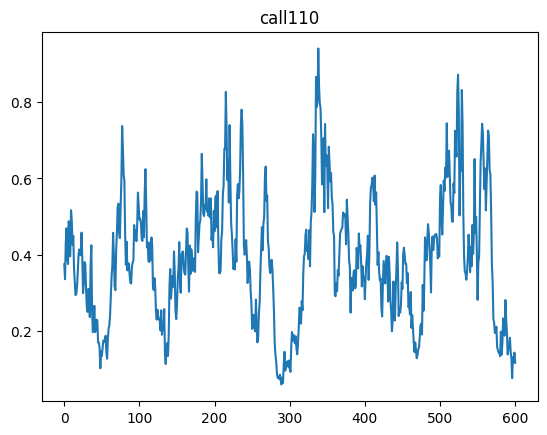

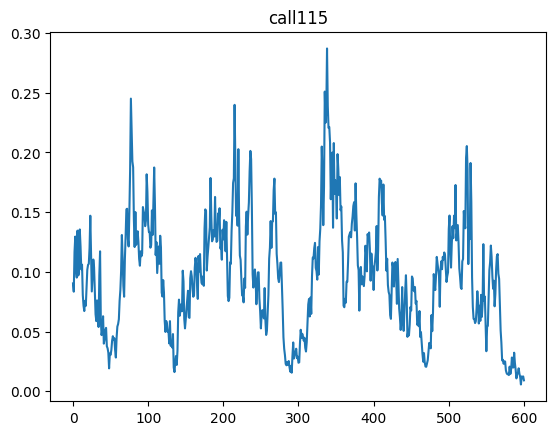

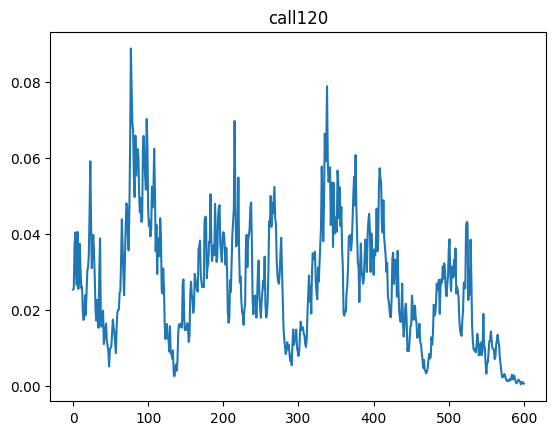

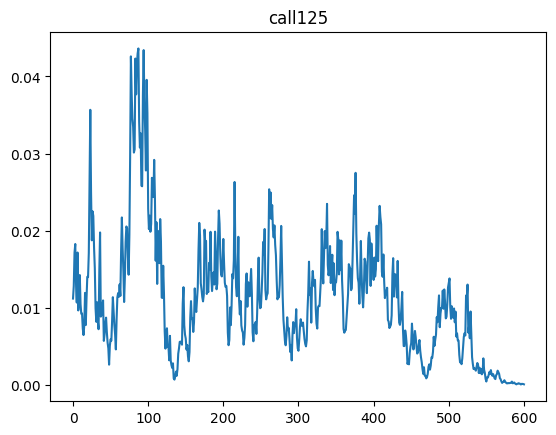

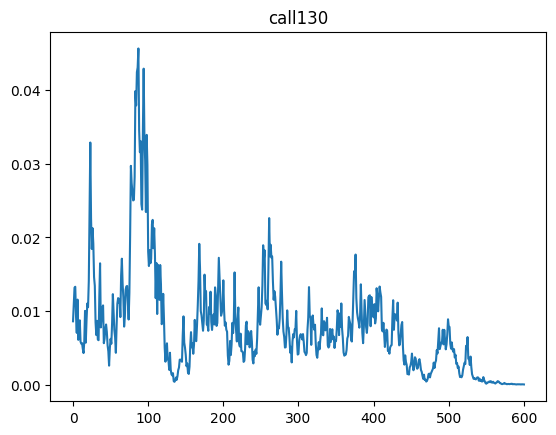

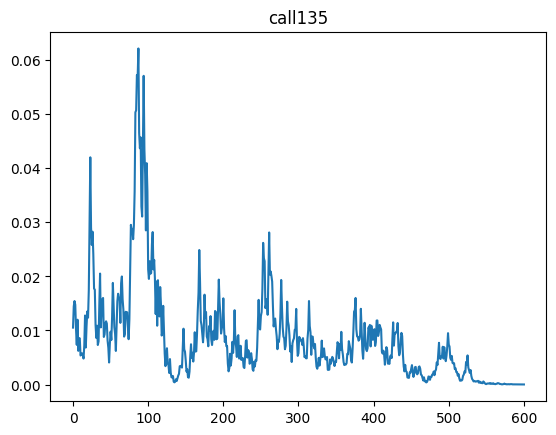

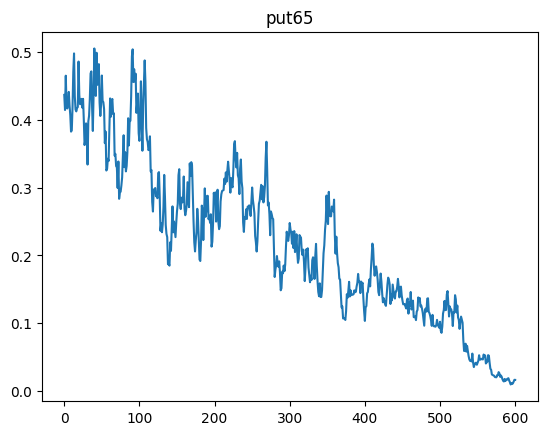

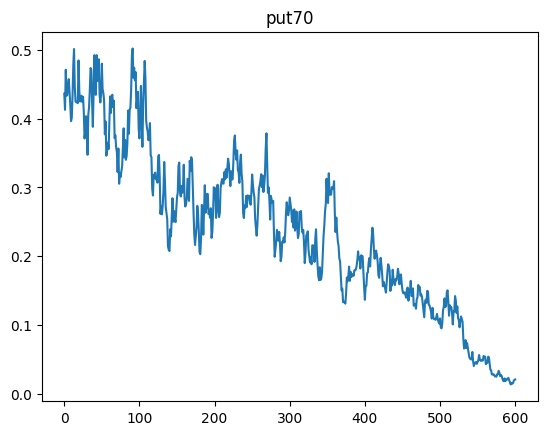

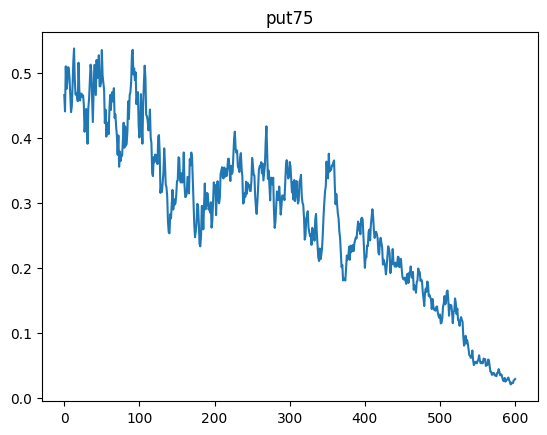

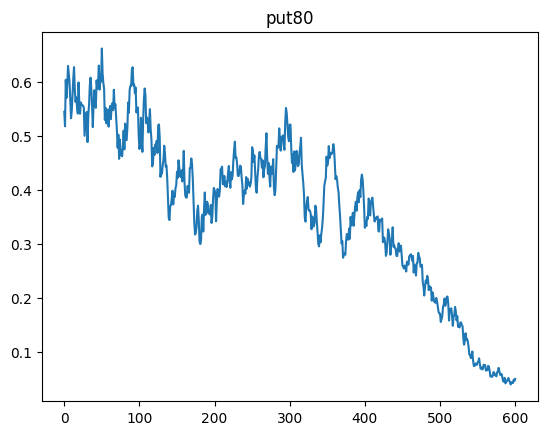

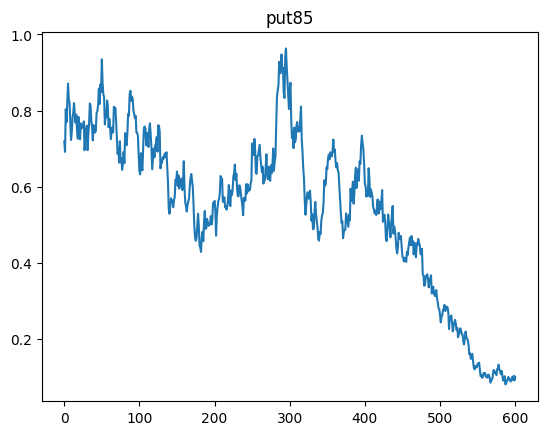

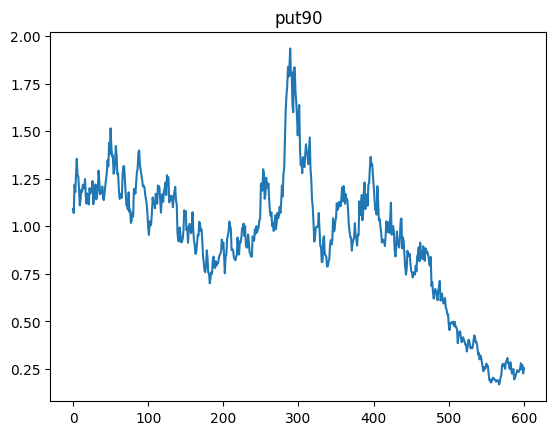

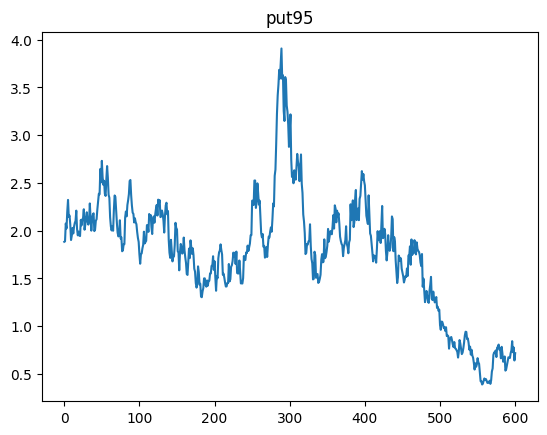

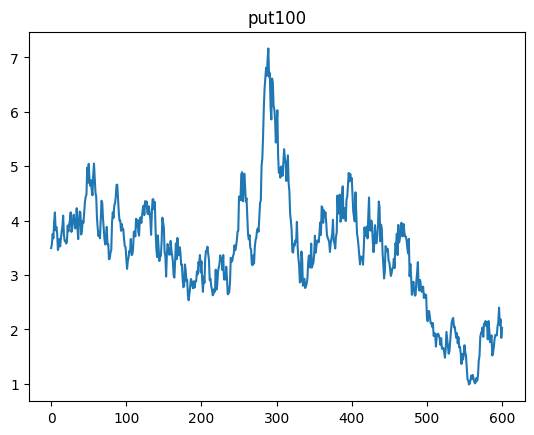

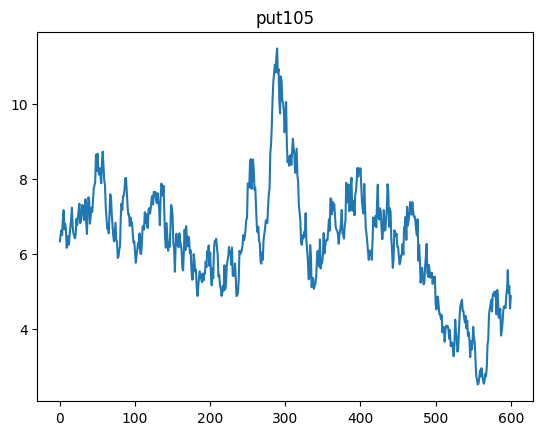

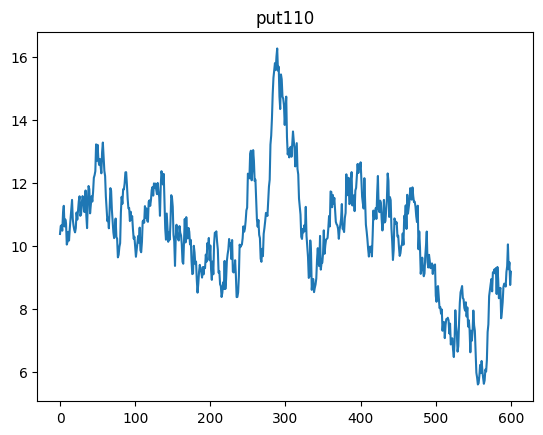

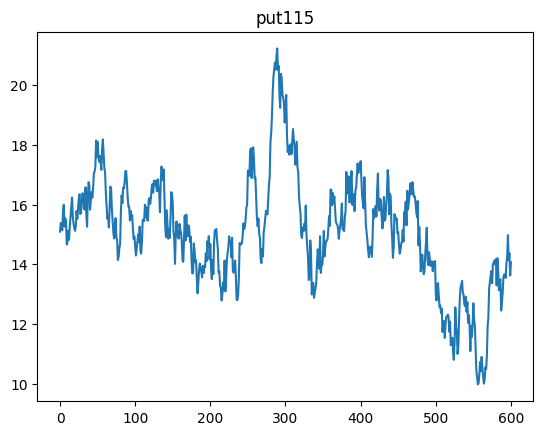

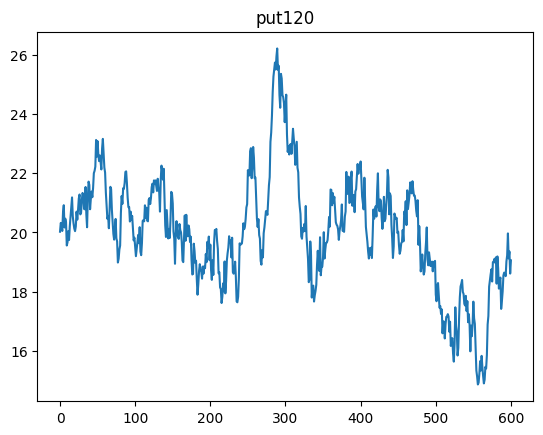

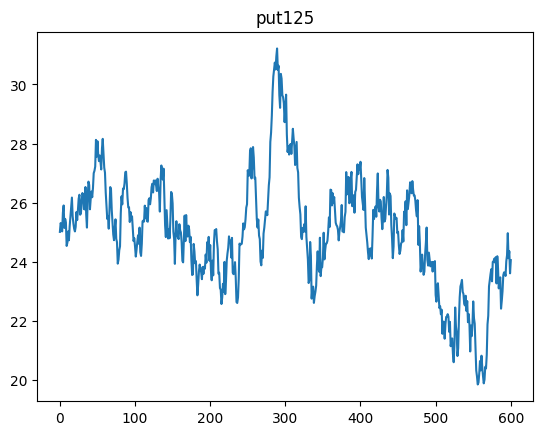

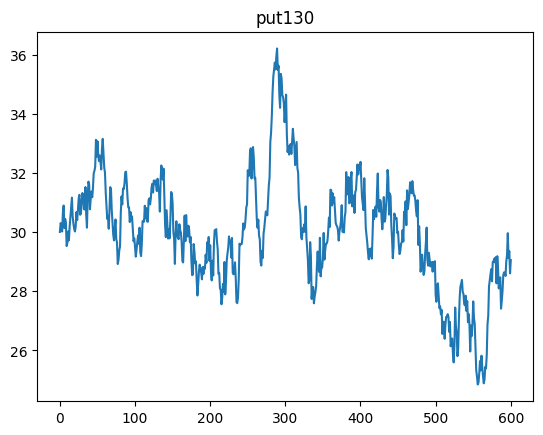

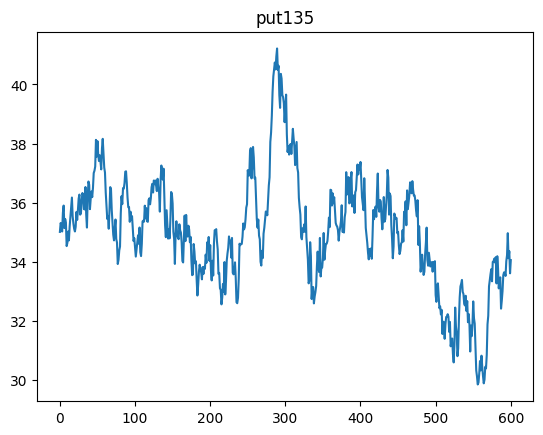

In [26]:
options = df.columns[2:].to_numpy()
for option_name in options:
    option_price = df[option_name].to_numpy()
    
    plt.title(option_name)
    plt.plot(option_price)
    plt.show()

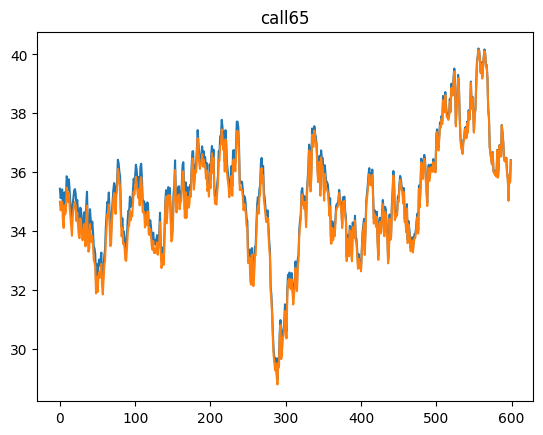

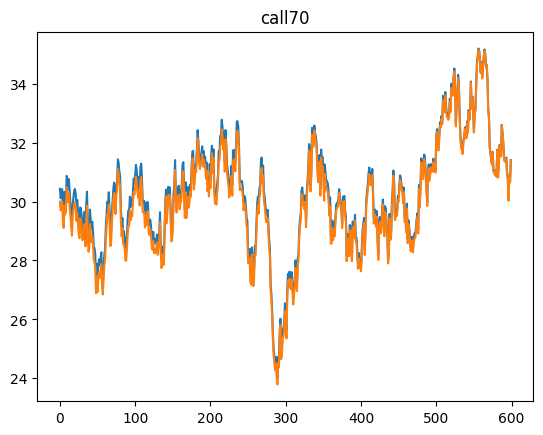

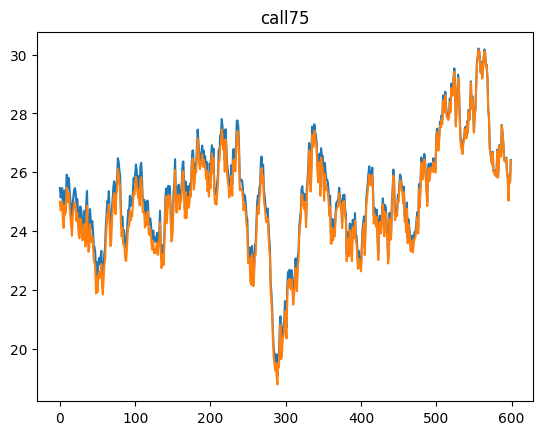

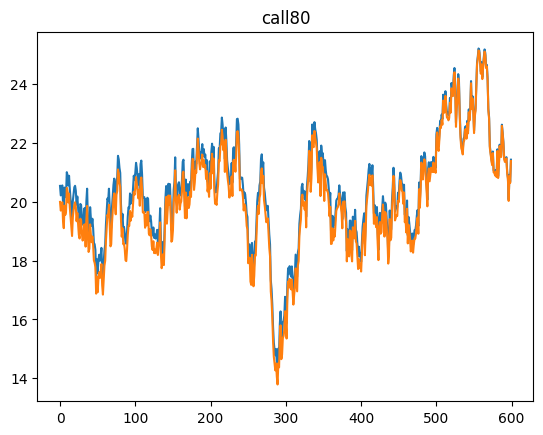

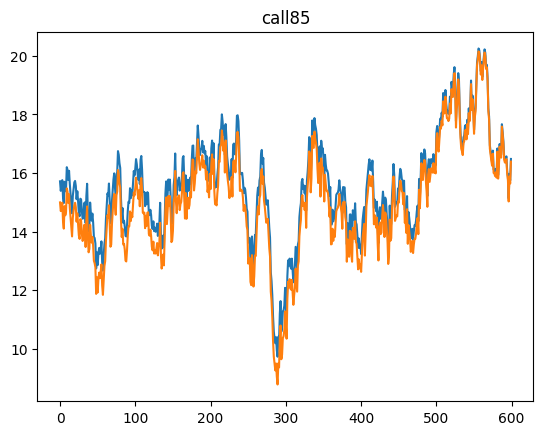

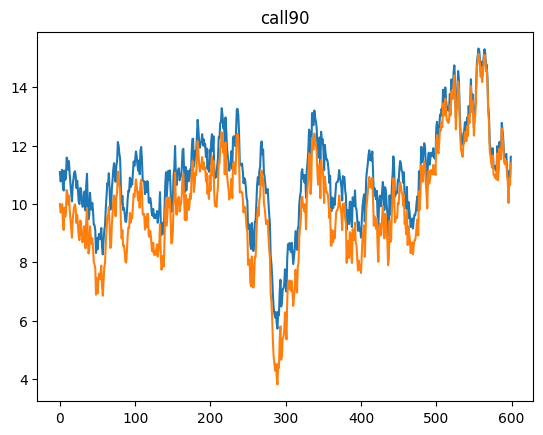

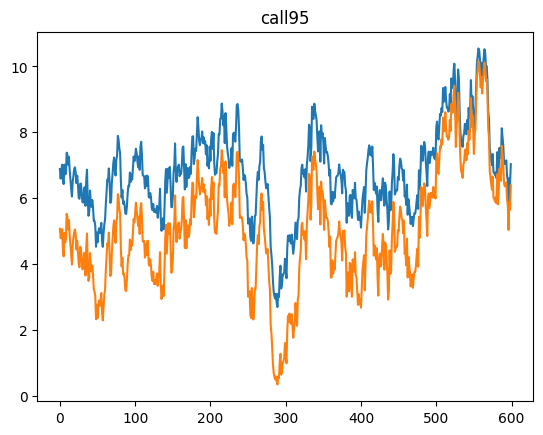

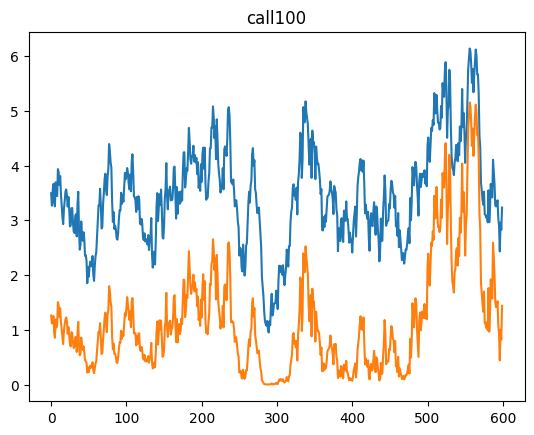

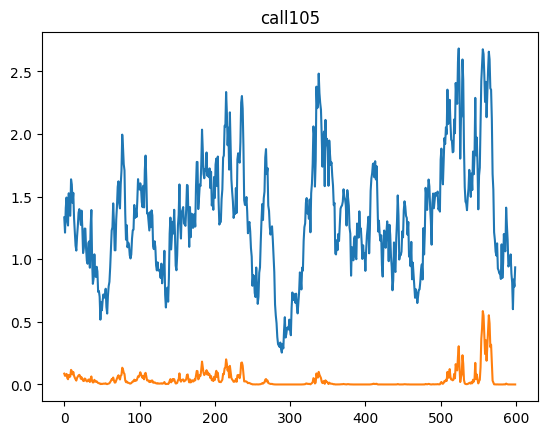

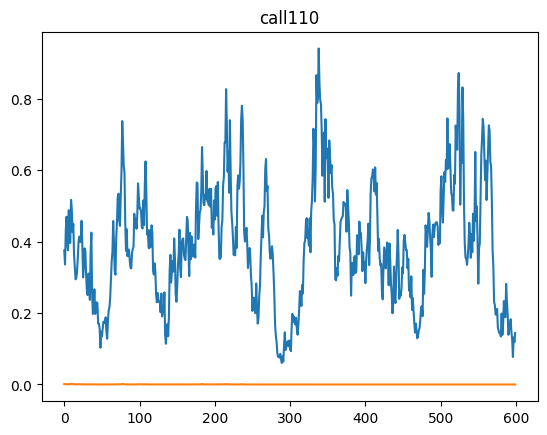

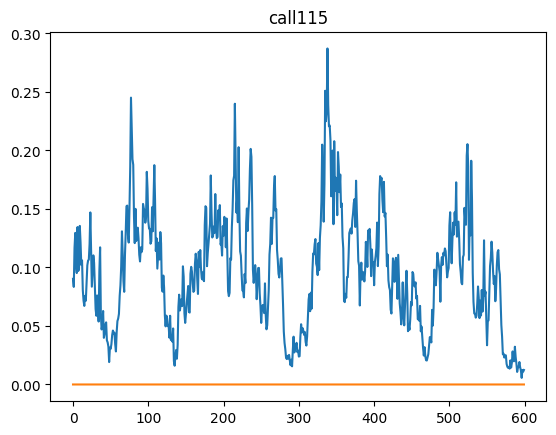

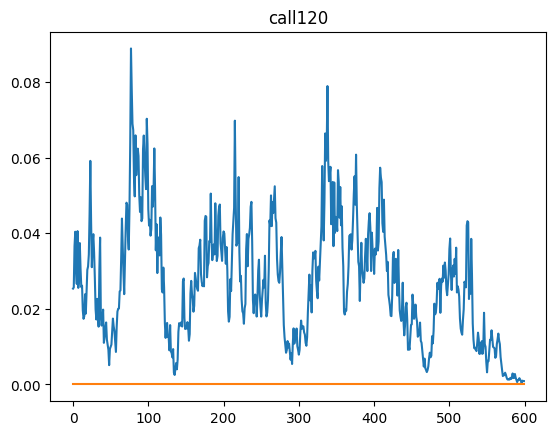

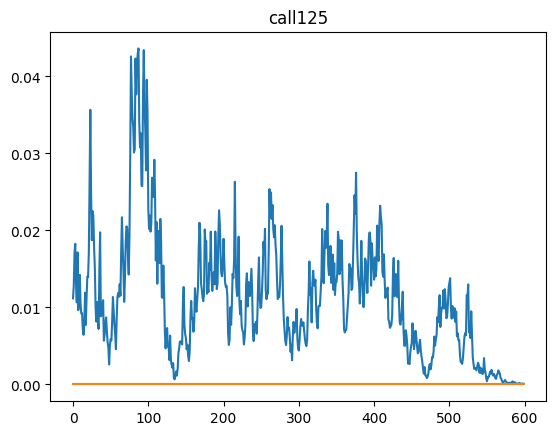

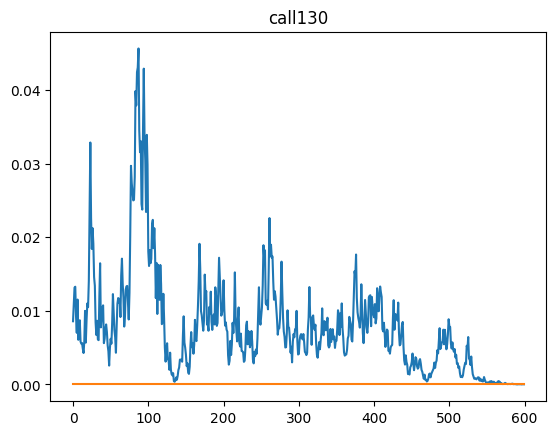

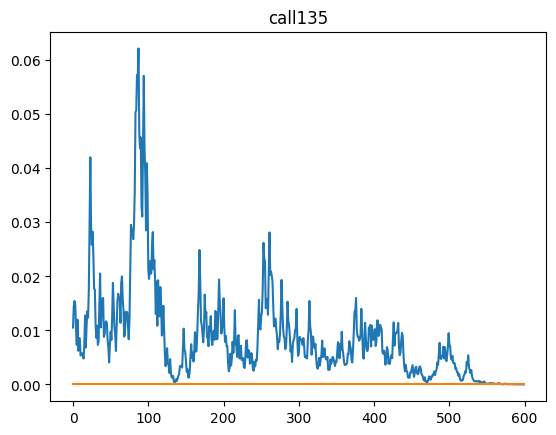

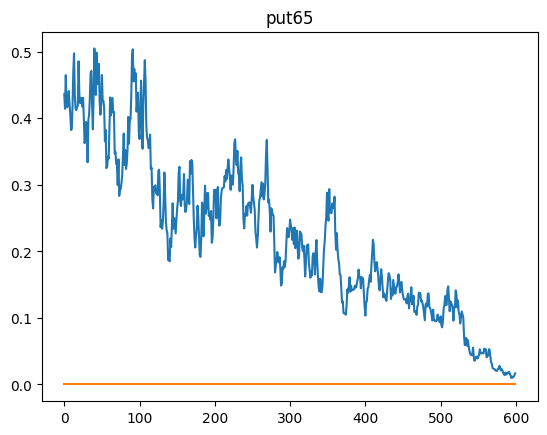

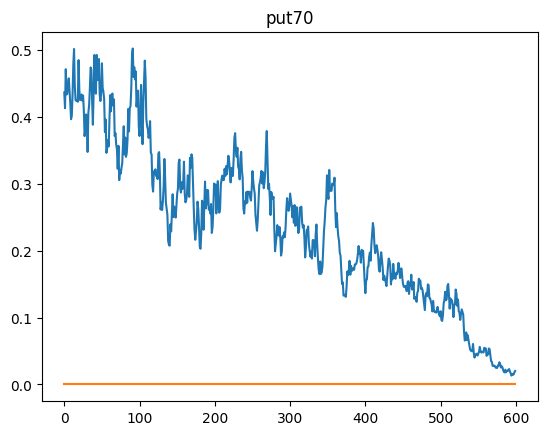

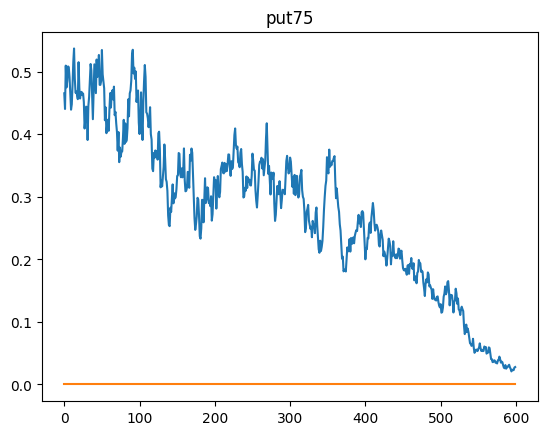

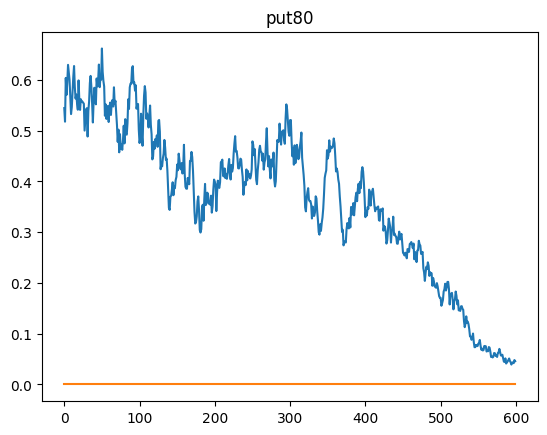

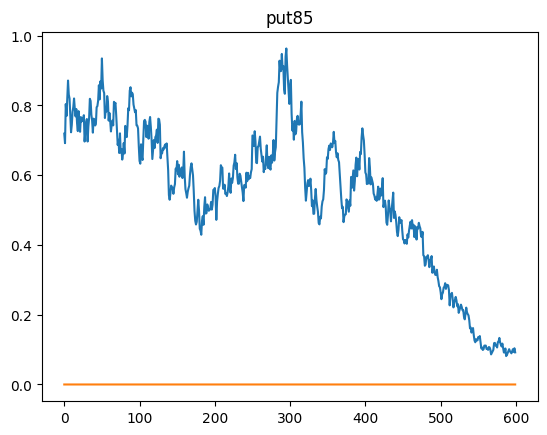

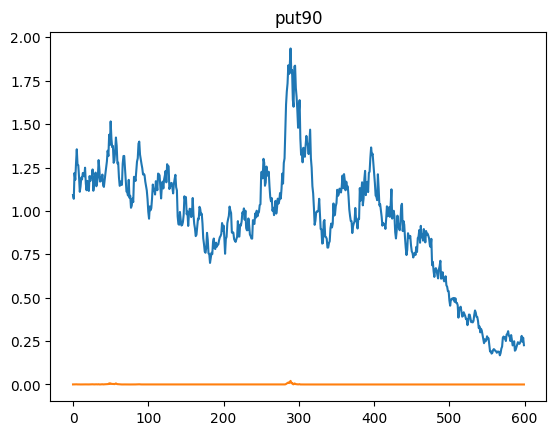

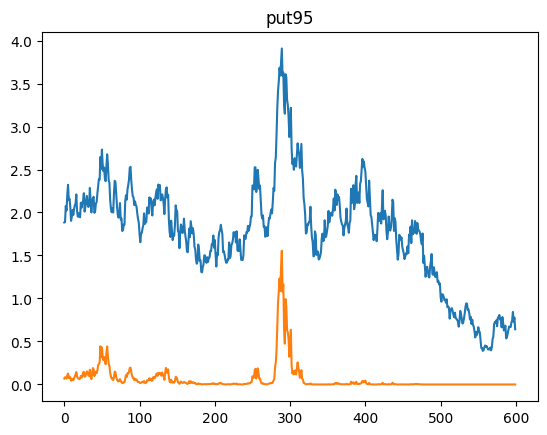

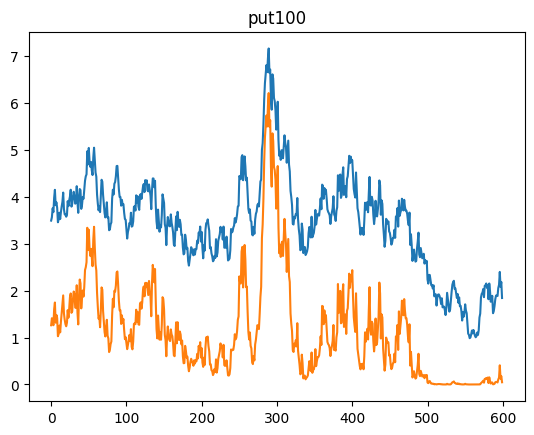

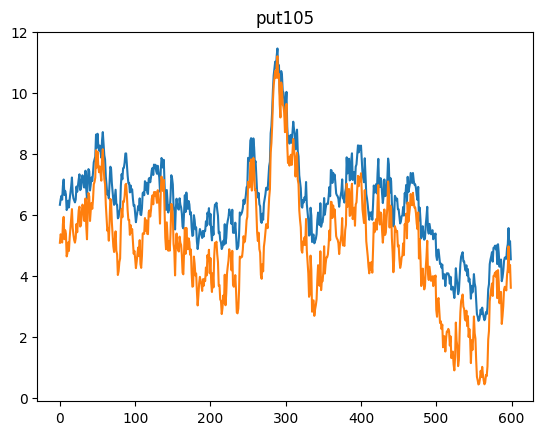

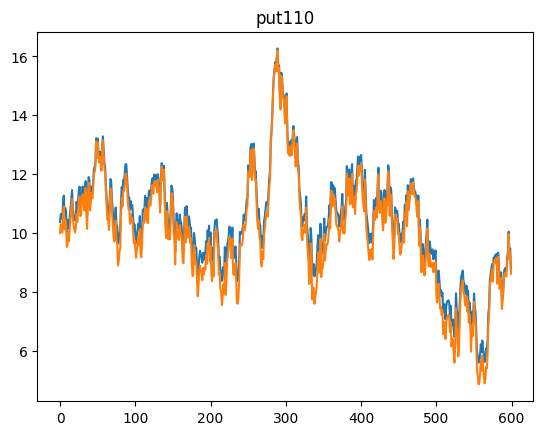

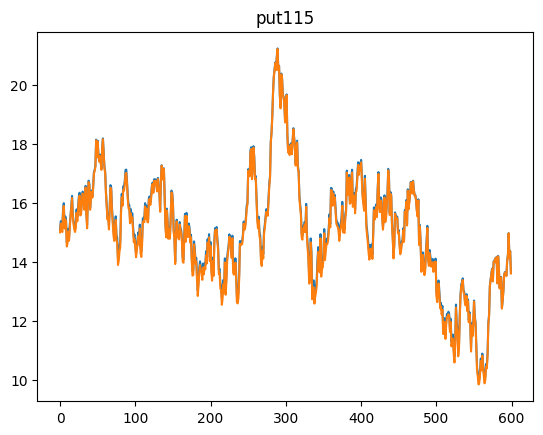

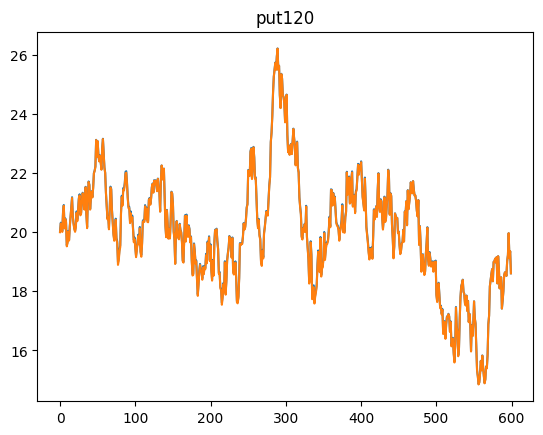

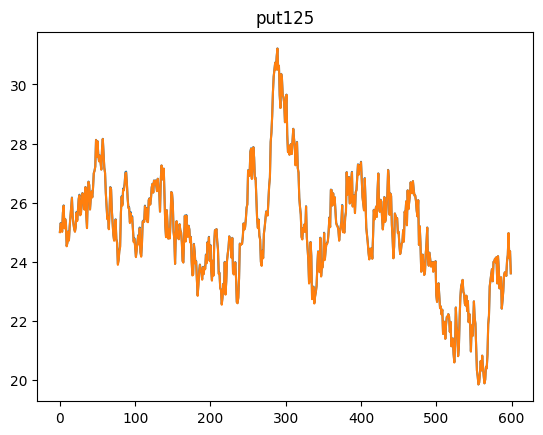

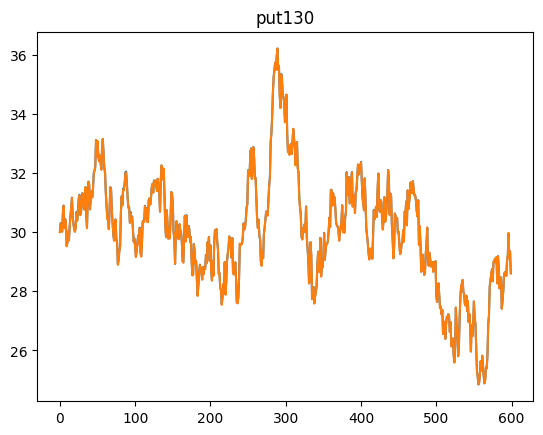

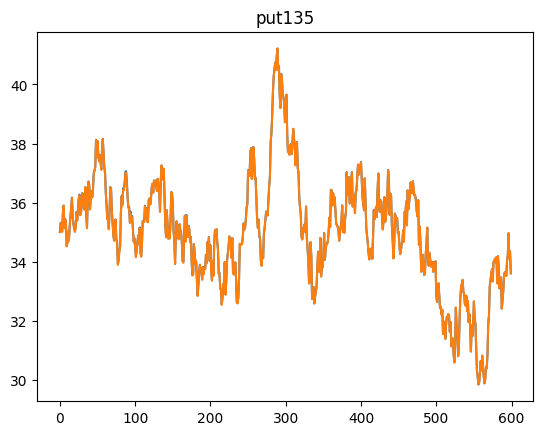

In [182]:
def d(sigma, S, K, r, t):
    d1 = 1 / (sigma * np.sqrt(t)) * ( np.log(S / K) + (r + sigma**2 / 2) * t)
    d2 = d1 - sigma * np.sqrt(t)
    return d1, d2

def call_price(sigma, S, K, r, t, d1, d2):
    C = norm.cdf(d1) * S - norm.cdf(d2) * K * np.exp(-r * t)
    return C

def put_price(sigma, S, K, r, t, d1, d2):
    P = -norm.cdf(-d1) * S + norm.cdf(-d2) * K * np.exp(-r * t)
    return P

def vega(sigma, S, K, r, t):
    d1, d2 = d(sigma, S, K, r, t)
    v = S * norm.pdf(d1) * np.sqrt(t)
    return v

def delta(d_1, contract_type):
    if contract_type == 'C':
        return norm.cdf(d_1)
    if contract_type == 'P':
        return -norm.cdf(-d_1)
    
def gamma(d2, S, K, sigma, r, t):
    return(K * np.exp(-r * t) * (norm.pdf(d2) / (S**2 * sigma * np.sqrt(t)))) 

def theta(d1, d2, S, K, sigma, r, t, contract_type):
    if contract_type == 'C':
        theta = -S * sigma * norm.pdf(d1) / (2 * np.sqrt(t)) - r * K * np.exp(-r * t) * norm.cdf(d2)
    if contract_type == 'P':
        theta = -S * sigma * norm.pdf(-d1) / (2 * np.sqrt(t)) + r * K * np.exp(-r * t) * norm.cdf(-d2)
    return theta

def implied_vol(sigma, S, K, r, t, bs_price, price):
    val = bs_price - price
    veg = vega(sigma, S, K, r, t)
    vol = -val / veg + sigma
    return vol

asset_price_returns = (asset_price[1:] - asset_price[:-1])/asset_price[:-1]

time_to_expiry = np.linspace(0.25, 0.0833, 600)
strike_price_list = [65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135]
options = df.columns[2:].to_numpy()
for option_name in options:
    option_price = df[option_name].to_numpy()
    bs_price = np.zeros(600)
    
    Call = True
    strike_price = int(option_name[4:])
    if option_name[0] == 'p':
        Call = False
        strike_price = int(option_name[3:])
    
    for timestamp in range(600):
        #sigma = np.sqrt((time_to_expiry[timestamp])*600) * ((asset_price[1:timestamp] - asset_price[:timestamp-1]) / asset_price[:timestamp-1]).std() 
        sigma = np.sqrt((time_to_expiry[timestamp])*600) * asset_price_returns.std()
        #volatility = implied_vol(sigma, S, K, 0, time_to_expiry[timestamp], bs_price, price)
        #volatility = np.sqrt((time_to_expiry[timestamp])*600) * ((asset_price[1:timestamp] - asset_price[:timestamp-1]) / asset_price[:timestamp-1]).std()
        volatility = np.sqrt((time_to_expiry[timestamp])*600) * asset_price_returns.std()        
        
        d1, d2 = d(volatility, asset_price[timestamp], strike_price, 0, time_to_expiry[timestamp])
        
        if Call == True:
            bs_price[timestamp] = call_price(volatility, asset_price[timestamp], strike_price, 0, time_to_expiry[timestamp], d1, d2)            
        else:
            bs_price[timestamp] = put_price(volatility, asset_price[timestamp], strike_price, 0, time_to_expiry[timestamp], d1, d2)
            
            
    plt.title(option_name)
    plt.plot(option_price[:-1])
    plt.plot(bs_price)
    plt.show()
    



In [239]:
class StockOption(object):

    def __init__(self, S0, K, r, T, N, params):
        self.S0 = S0
        self.K = K
        self.r = r
        self.T = T
        self.N = max(1, N) # Ensure N have at least 1 time step
        self.STs = None  # Declare the stock prices tree
        
        """ Optional parameters used by derived classes """
        self.pu = params.get("pu", 0)  # Probability of up state
        self.pd = params.get("pd", 0)  # Probability of down state
        self.div = params.get("div", 0)  # Dividend yield
        self.sigma = params.get("sigma", 0)  # Volatility
        self.is_call = params.get("is_call", True)  # Call or put
        self.is_european = params.get("is_eu", True)  # Eu or Am

        """ Computed values """
        self.dt = T/float(N)  # Single time step, in years
        self.df = math.exp(
            -(r-self.div) * self.dt)  # Discount factor
        
        
        
class BinomialEuropeanOption(StockOption):

    def __setup_parameters__(self):
        """ Required calculations for the model """
        self.M = self.N + 1  # Number of terminal nodes of tree
        self.u = 1 + self.pu  # Expected value in the up state
        self.d = 1 - self.pd  # Expected value in the down state
        self.qu = (math.exp((self.r-self.div)*self.dt) -
                   self.d) / (self.u-self.d)
        self.qd = 1-self.qu

    def _initialize_stock_price_tree_(self):
        # Initialize terminal price nodes to zeros
        self.STs = np.zeros(self.M)

        # Calculate expected stock prices for each node
        for i in range(self.M):
            self.STs[i] = self.S0*(self.u**(self.N-i))*(self.d**i)

    def _initialize_payoffs_tree_(self):
        # Get payoffs when the option expires at terminal nodes
        payoffs = np.maximum(
            0, (self.STs-self.K) if self.is_call
            else(self.K-self.STs))

        return payoffs

    def _traverse_tree_(self, payoffs):
        # Starting from the time the option expires, traverse
        # backwards and calculate discounted payoffs at each node
        for i in range(self.N):
            payoffs = (payoffs[:-1] * self.qu +
                       payoffs[1:] * self.qd) * self.df

        return payoffs

    def __begin_tree_traversal__(self):
        payoffs = self._initialize_payoffs_tree_()
        return self._traverse_tree_(payoffs)

    def price(self):
        """ The pricing implementation """
        self.__setup_parameters__()
        self._initialize_stock_price_tree_()
        payoffs = self.__begin_tree_traversal__()

        return payoffs[0]  # Option value converges to first node


class BinomialLROption(BinomialEuropeanOption):

    def _setup_parameters_(self):
        odd_N = self.N if (self.N%2 == 1) else (self.N+1)
        d1 = (math.log(self.S0/self.K) +
              ((self.r-self.div) +
               (self.sigma**2)/2.) *
              self.T) / (self.sigma * math.sqrt(self.T))
        d2 = (math.log(self.S0/self.K) +
              ((self.r-self.div) -
               (self.sigma**2)/2.) *
              self.T) / (self.sigma * math.sqrt(self.T))
        pp_2_inversion = \
            lambda z, n: \
            .5 + math.copysign(1, z) * \
            math.sqrt(.25 - .25 * math.exp(
                -((z/(n+1./3.+.1/(n+1)))**2.)*(n+1./6.)))
        pbar = pp_2_inversion(d1, odd_N)

        self.p = pp_2_inversion(d2, odd_N)
        self.u = 1/self.df * pbar/self.p
        self.d = (1/self.df - self.p*self.u)/(1-self.p)
        self.qu = self.p
        self.qd = 1-self.p


asset_price_returns = (asset_price[1:] - asset_price[:-1])/asset_price[:-1]
np.abs((asset_price[1:] - asset_price[:-1]))

time_to_expiry = np.linspace(0.25, 0.0833, 600)
#S0, K, r, T, N, prob_up, prob_down
eu_option_prices = np.zeros(600)
for timestamp in range(600):
    sigma = np.sqrt((time_to_expiry[timestamp])*600) * asset_price_returns.std()
    prob_up = norm((100), asset_price.std()).cdf(asset_price) * asset_price_returns.std()
    
    prob_down = 1 - prob_up
    eu_option = BinomialLROption(asset_price[timestamp], 135, 0, time_to_expiry[timestamp], 900-timestamp, \
                                 {"pu": prob_up*asset_price_returns.std(), "pd": prob_down*asset_price_returns.std(), "sigma": sigma, "is_call": True})
    eu_option_prices[timestamp] = eu_option.price()
plt.plot(eu_option_prices)
plt.plot(df['call135'].to_numpy())
plt.show()

[2.58398327e-03 2.26455536e-03 2.34852901e-03 2.57308737e-03
 1.89336128e-03 1.65120342e-03 2.44639484e-03 2.11194670e-03
 2.23738312e-03 3.09505974e-03 2.97196341e-03 2.56523079e-03
 2.88827039e-03 2.37953626e-03 2.02632522e-03 1.71129033e-03
 1.40233651e-03 2.02348858e-03 2.28188192e-03 2.47330191e-03
 2.57015844e-03 2.40588648e-03 1.88661388e-03 2.18174319e-03
 1.81995039e-03 1.43937465e-03 1.32803791e-03 1.97632040e-03
 1.91909667e-03 1.49260679e-03 1.26634126e-03 1.34029606e-03
 1.76781934e-03 1.78074616e-03 1.09836063e-03 1.95449094e-03
 2.43604399e-03 1.41164407e-03 9.61346863e-04 1.04756511e-03
 1.77883018e-03 1.43541098e-03 1.21996898e-03 1.38899072e-03
 1.12586934e-03 7.65698736e-04 7.15432160e-04 6.33530125e-04
 2.62728085e-04 4.67487328e-04 2.76403510e-04 4.40126054e-04
 5.39842569e-04 4.52505617e-04 5.53017127e-04 6.90326543e-04
 3.55067199e-04 2.53509295e-04 4.35563795e-04 6.56620519e-04
 7.59698234e-04 1.25893716e-03 1.67982044e-03 2.11498527e-03
 2.03085981e-03 2.477411

ValueError: setting an array element with a sequence.

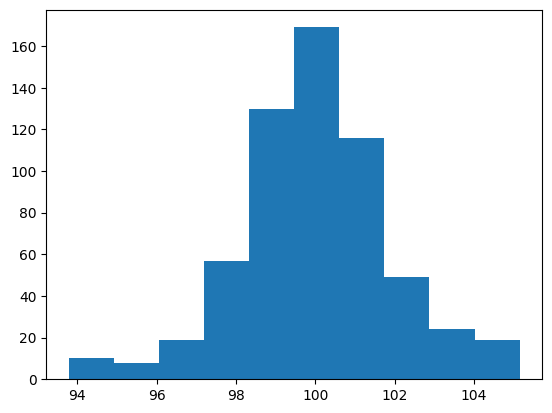

1.9070030030882308
100.0085371953627


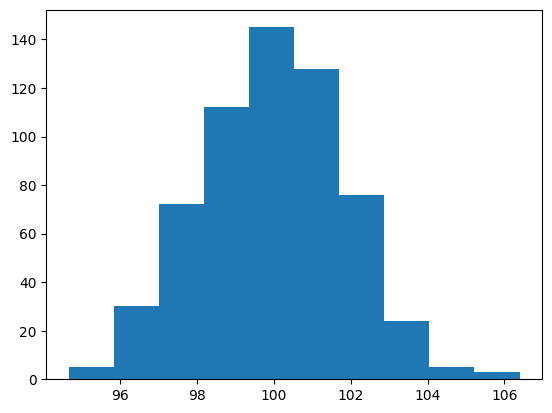

0.5

In [235]:
plt.hist(asset_price)
plt.show()
print(asset_price.std())
print(np.average(asset_price))
s = np.random.normal(np.average(asset_price), asset_price.std(), 600)
plt.hist(s)
plt.show()
